In [2]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Imports for ML and XAI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, Callback
import shap
import lime
import lime.lime_tabular

# Set plot style
sns.set(style="whitegrid")

In [4]:
# Load the main cleaned dataset
# This reviews df will be used for both analysis and feature engineering

reviews = pd.read_csv("AirlineScrappedReview_cleaned_final.csv")
print(f"Original dataset loaded with {len(reviews)} rows.")
reviews.head()

Original dataset loaded with 3501 rows.


,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,Paige Boet,2023-06-01,New Orleans to London,1,0,The airline lost my luggage,The airline lost my luggage and was absolutely...,solo leisure,economy class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,2023-03-01,London to Amman,1,0,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",couple leisure,business class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,1900-01-01,Heathrow to Bodrum,2,0,no boarding drinks provided,"First time flying with BA business class, neve...",solo leisure,business class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"
3,Joel Burman,2023-06-01,Amman to London,4,0,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,solo leisure,economy class,Amman,London,NaN,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
4,R Vines,1900-01-01,London City to Ibiza,7,0,stick with economy,This is a two-for-one review covering economy ...,family leisure,business class,London City,Ibiza,NaN,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España"


Sentiment analysis added.


/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/3603264617.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=reviews, palette='viridis')
/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/3603264617.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=reviews, palette='plasma')
/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/3603264617.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_routes.index, x=top_routes.values, palette='cool')


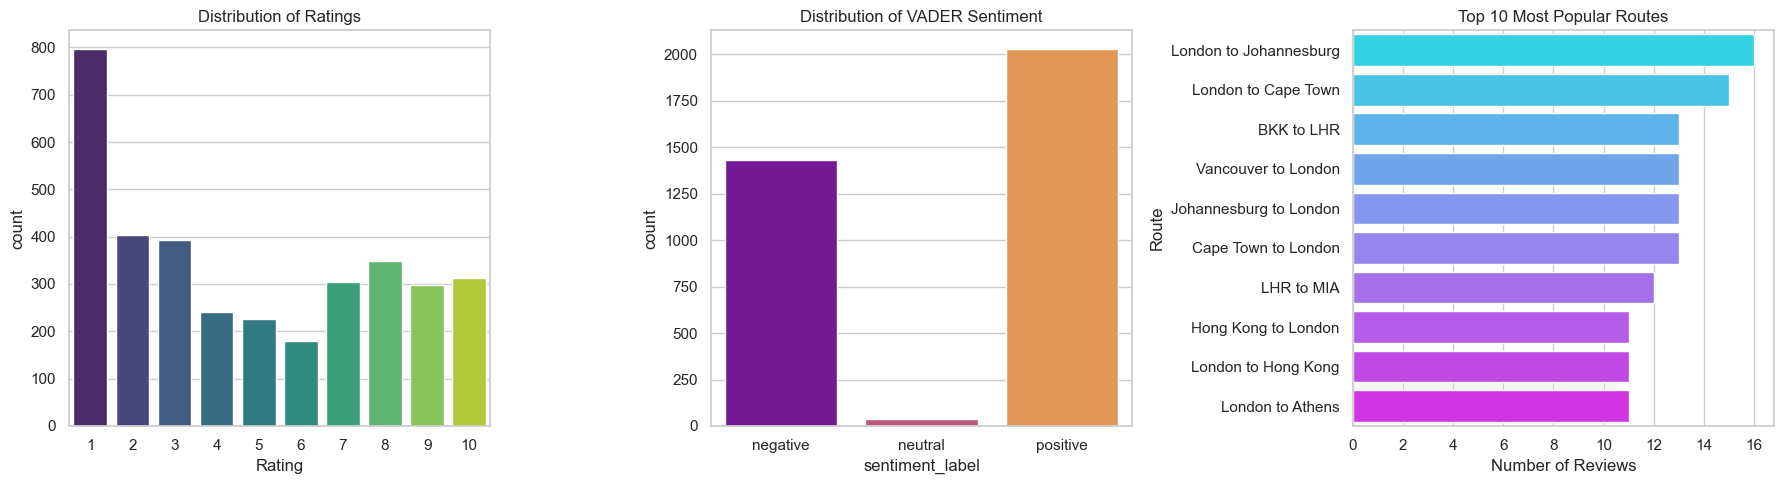

In [5]:
#  Add VADER Sentiment Analysis columns
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return np.nan
    return analyzer.polarity_scores(str(text))['compound']

def sentiment_label(compound):
    if pd.isna(compound):
        return "neutral"  # Fillna with neutral
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

reviews['sentiment_compound'] = reviews['Review_content'].apply(get_sentiment)
reviews['sentiment_label'] = reviews['sentiment_compound'].apply(sentiment_label)

print("Sentiment analysis added.")

#  Plot Analysis
plt.figure(figsize=(18, 5))

# Plot Rating Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='Rating', data=reviews, palette='viridis')
plt.title('Distribution of Ratings')

# Plot Sentiment Distribution
plt.subplot(1, 3, 2)
sns.countplot(x='sentiment_label', data=reviews, palette='plasma')
plt.title('Distribution of VADER Sentiment')

# Plot Top 10 Routes
top_routes = reviews['Route'].value_counts().head(10)
plt.subplot(1, 3, 3)
sns.barplot(y=top_routes.index, x=top_routes.values, palette='cool')
plt.title('Top 10 Most Popular Routes')
plt.xlabel('Number of Reviews')
plt.ylabel('Route')

plt.tight_layout()
plt.show()

In [6]:
# Save the augmented dataset as required 
output_path = "AirlineScrappedReview_with_sentiment.csv"
reviews.to_csv(output_path, index=False)
print(f"Saved augmented dataset to: {output_path}")

Saved augmented dataset to: AirlineScrappedReview_with_sentiment.csv


In [7]:


print("Starting feature engineering for the model...")

#  TARGET CREATION
reviews = reviews.dropna(subset=["Rating"])  # ensure no target is missing
reviews["satisfaction"] = np.where(reviews["Rating"] >= 5, 1, 0)

#  CLEAN / HANDLE MISSING VALUES
categorical_cols = reviews.select_dtypes(include=['object']).columns.tolist()
if 'sentiment_label' not in categorical_cols:
     categorical_cols.append('sentiment_label')
            
numerical_cols = reviews.select_dtypes(include=['float64','int64']).columns.tolist()

reviews[categorical_cols] = reviews[categorical_cols].fillna("Unknown")
if 'Rating' in numerical_cols:
    numerical_cols.remove('Rating') # Don't fill the target base
if 'sentiment_compound' in numerical_cols:
    numerical_cols.remove('sentiment_compound') # Don't use compound score directly

# Fill numeric NaNs with median
# Get median of numerical columns (excluding those just removed)
median_values = reviews[numerical_cols].median()
reviews[numerical_cols] = reviews[numerical_cols].fillna(median_values)


#  BASIC FEATURE ENGINEERING
if 'Verified' in reviews.columns:
    reviews["verified_flag"] = reviews["Verified"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)
else:
    reviews["verified_flag"] = 0

reviews["title_length"] = reviews["Review_title"].astype(str).apply(len)
reviews["content_length"] = reviews["Review_content"].astype(str).apply(len)

reviews["Flying_Date"] = pd.to_datetime(reviews["Flying_Date"], errors="coerce")
reviews["flight_dayofweek"] = reviews["Flying_Date"].dt.dayofweek.fillna(-1)
reviews["flight_month"] = reviews["Flying_Date"].dt.month.fillna(-1)

if "Route" in reviews.columns:
    reviews["origin"] = reviews["Route"].apply(lambda x: str(x).split("-")[0] if "-" in str(x) else "Unknown")
    reviews["destination"] = reviews["Route"].apply(lambda x: str(x).split("-")[-1] if "-" in str(x) else "Unknown")
else:
    reviews["origin"] = "Unknown"
    reviews["destination"] = "Unknown"

#  ENCODE CATEGORICAL FEATURES
categorical_features = ["Traveller_Type", "Class", "origin", "destination", "sentiment_label"]

# Ensure all columns exist before encoding
existing_cat_features = [col for col in categorical_features if col in reviews.columns]
reviews_encoded = pd.get_dummies(reviews, columns=existing_cat_features, drop_first=True)

#  SAVE MODEL-READY DATASET

# We must drop ALL original text, date, and geographic columns that are not features.
cols_to_drop = [
    "Passanger_Name", "Review_title", "Review_content", "Flying_Date", "Route", 
    "sentiment_compound", "Verified", "Start_Location", "End_Location", 
    "Layover_Route", "Start_Address", "End_Address", "flight_day", "flight_hour"
]

model_df = reviews_encoded.drop(columns=[col for col in cols_to_drop if col in reviews_encoded.columns], errors="ignore")

model_df.to_csv("reviews_model_ready.csv", index=False)
print(f"✅ Data cleaning & feature engineering completed. Model-ready file saved as 'reviews_model_ready.csv'")
print(f"Shape: {model_df.shape}")
print("Checking for any remaining non-numeric columns:")
print(model_df.select_dtypes(include=['object']).columns.tolist())

Starting feature engineering for the model...
✅ Data cleaning & feature engineering completed. Model-ready file saved as 'reviews_model_ready.csv'
Shape: (3501, 47)
Checking for any remaining non-numeric columns:
[]


##  Data Analysis and Engineering

As required, we first analyze the data to understand its properties and answer key data engineering questions.

### Q1: What is the distribution of user ratings?
The `Rating` column is our primary indicator of satisfaction. We can see a U-shaped distribution, with a very high number of 1-star reviews and a high number of 8-10 star reviews. This confirms the data is highly polarized, making it a good candidate for binary "Satisfied" vs. "Dissatisfied" classification.

### Q2: What is the overall sentiment of the review text?
We use the VADER sentiment analyzer to score the `Review_content` text. The plot below shows that, similar to the ratings, the text sentiment is also polarized, with a large number of "negative" reviews. This `sentiment_label` will be a crucial feature for our model.

### Q3: What are the most common flight routes?
Analyzing the `Route` column shows the most frequently reviewed routes. Routes like "London to Johannesburg" and "London to Cape Town" are very common, which is expected for British Airways. We will engineer `origin` and `destination` features from this column.

##  Feature Selection & Engineering

Based on the analysis and project goals, we will engineer and select features that we hypothesize will influence passenger satisfaction.

* **Target (`satisfaction`):** We create our binary target variable directly from `Rating`, where a rating >= 5 is 1 (Satisfied) and < 5 is 0 (Dissatisfied).
* **Text-Based Features:**
    * `sentiment_label`: This is the VADER sentiment (positive, negative, neutral) we just engineered. This is a vital feature as it directly quantifies the opinion in the text.
    * `content_length`: The length of the review. We hypothesize that very long reviews are often associated with strong negative experiences.
* **Categorical Features:**
    * `Traveller_Type` & `Class`: A business traveler in economy may have different expectations than a family on leisure. These are key contextual features.
* **Route Features:**
    * `origin` & `destination`: We extract these from the `Route` column to see if specific locations impact satisfaction.
* **Date Features:**
    * `flight_dayofweek` & `flight_month`: To capture any seasonal or weekly patterns (e.g., busy weekends).
* **Verification:**
    * `verified_flag`: A simple binary flag from the `Verified` column.

##  Predictive Model (FFNN)

### Model Choice
For this milestone, we chose a simple Feed-Forward Neural Network (FFNN).
* **Why FFNN?** FFNNs are effective baseline models for binary classification on tabular data. They can capture complex, non-linear relationships between our engineered features (like review length, class, and sentiment) that a simple logistic regression might miss.
* **Limitations:** This model is a "black box," meaning it's not inherently interpretable. That is why we will apply XAI techniques (SHAP and LIME) to understand its predictions, as required. It can also be prone to overfitting, which we mitigate using Dropout layers and Early Stopping.

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.6419 - loss: 0.6434
 — val_precision: 0.9004 | val_recall: 0.8801 | val_f1: 0.8902
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7625 - loss: 0.5274 - val_accuracy: 0.8964 - val_loss: 0.3444
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/stepy: 0.8438 - loss: 0.39
 — val_precision: 0.9308 | val_recall: 0.9064 | val_f1: 0.9184
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9027 - loss: 0.2847 - val_accuracy: 0.9232 - val_loss: 0.2085
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/stepy: 0.8750 - loss: 0.19
 — val_precision: 0.9689 | val_recall: 0.9326 | val_f1: 0.9504
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9254 - loss: 0.1972 - val_accuracy: 0.9536 - val_loss: 0.1540
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/stepy: 0.9062 - loss: 0.14
 — val_precision: 0.9807 | val_recall: 0.9513 | val_f1: 0.9658
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9558 - loss: 0.1394 - val_accuracy: 0.

Epoch 27/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/stepy: 1.0000 - loss: 0.00
 — val_precision: 1.0000 | val_recall: 0.9925 | val_f1: 0.9962
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0061 - val_accuracy: 0.9964 - val_loss: 0.0958
Epoch 28/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/stepy: 1.0000 - loss: 0.01
 — val_precision: 1.0000 | val_recall: 0.9925 | val_f1: 0.9962
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0051 - val_accuracy: 0.9964 - val_loss: 0.0975


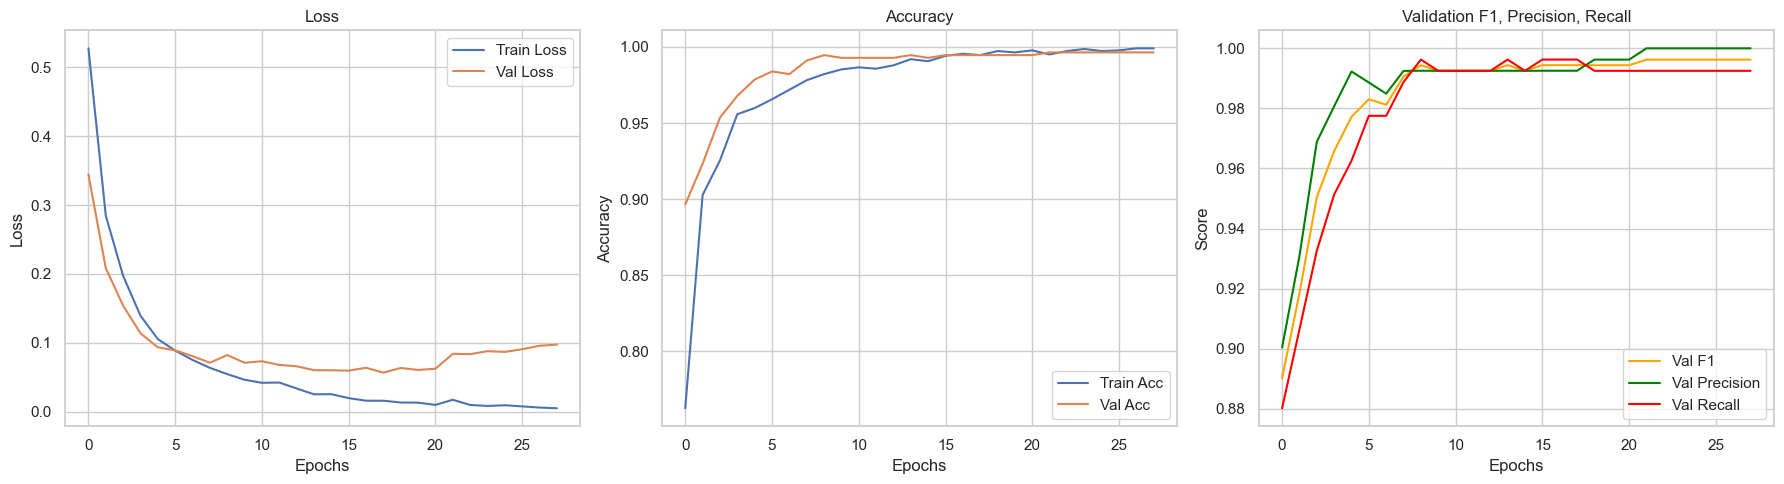

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
=== TEST SET PERFORMANCE ===
Accuracy:  0.9986
Precision: 0.9970
Recall:    1.0000
F1-Score:  0.9985
ROC-AUC:   0.9986

Confusion Matrix:


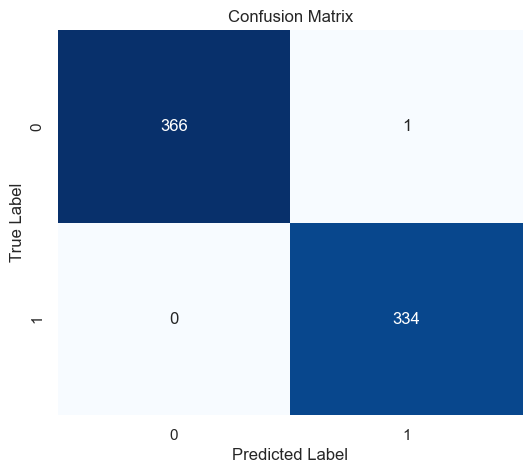


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       367
           1       1.00      1.00      1.00       334

    accuracy                           1.00       701
   macro avg       1.00      1.00      1.00       701
weighted avg       1.00      1.00      1.00       701



In [8]:


# ===============================
#  LOAD MODEL-READY DATA
# ===============================
df = pd.read_csv("reviews_model_ready.csv")

# ===============================
#  PREPARE FEATURES AND TARGET
# ===============================
# We must use all columns except satisfaction as features
# The 'Rating' column is still in df_model_ready and is highly predictive
X = df.drop(columns=["satisfaction"]) 
y = df["satisfaction"]

# Align columns to ensure consistency (in case some OHE columns were missing)
X = X.reindex(columns = X.columns, fill_value=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ===============================
#  CUSTOM CALLBACK FOR F1, PRECISION, RECALL
# ===============================
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.val_f1s = []
        self.val_precisions = []
        self.val_recalls = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(X_val) >= 0.5).astype(int)
        val_true = y_val.values
        precision_val = precision_score(val_true, val_pred, zero_division=0)
        recall_val = recall_score(val_true, val_pred, zero_division=0)
        f1_val = f1_score(val_true, val_pred, zero_division=0)

        self.val_precisions.append(precision_val)
        self.val_recalls.append(recall_val)
        self.val_f1s.append(f1_val)

        print(f" — val_precision: {precision_val:.4f} | val_recall: {recall_val:.4f} | val_f1: {f1_val:.4f}")

metrics_callback = MetricsCallback()

# ===============================
# BUILD FFNN MODEL (1 HIDDEN LAYER)
# ===============================
model = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),   # hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ===============================
# TRAIN MODEL WITH EARLY STOPPING
# ===============================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, metrics_callback],
    verbose=1
)

# ===============================
# PLOT TRAINING METRICS
# ===============================
plt.figure(figsize=(18,5))
# Loss
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
# Accuracy
plt.subplot(1,3,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
# F1 / Precision / Recall
plt.subplot(1,3,3)
plt.plot(metrics_callback.val_f1s, label='Val F1', color='orange')
plt.plot(metrics_callback.val_precisions, label='Val Precision', color='green')
plt.plot(metrics_callback.val_recalls, label='Val Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation F1, Precision, Recall')
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
#  EVALUATE ON TEST SET
# ===============================
y_test_prob = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("=== TEST SET PERFORMANCE ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}\n")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# ===============================
#  INFERENCE FUNCTION (Original - to be fixed)
# ===============================
# We also need the original feature list 'X' from this cell for the final function
feature_cols_list = X.columns.tolist()

def predict_satisfaction(new_df, scaler=scaler, model=model):
    """
    Original function.
    Accepts a DataFrame with the *same encoded features* as training data,
    scales numeric features, and returns predicted satisfaction (0 or 1).
    """
    X_new = new_df.copy()
    
    # Align columns with training data
    for col in X.columns:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[X.columns]  # ensure column order matches
    
    # Scale
    X_scaled = scaler.transform(X_new)
    
    # Predict
    prob = model.predict(X_scaled).flatten()
    pred = (prob >= 0.5).astype(int)
    
    return pred, prob

## Inference Function

The milestone requires an inference function that accepts raw input and returns a **natural language** prediction. The original function in the cell above does not do this.

Below is the **corrected inference function** (`predict_satisfaction_final`). It bundles all the preprocessing steps (sentiment analysis, feature engineering, encoding, and scaling) into a single pipeline. It takes a raw dataframe row and returns "Satisfied" or "Dissatisfied".

We also demonstrate this function with two examples as required.

In [9]:


# We need the VADER analyzer again
analyzer = SentimentIntensityAnalyzer()

def predict_satisfaction_final(raw_df, scaler_obj=scaler, model_obj=model, feature_cols=feature_cols_list):
    """
    Accepts a DataFrame with RAW features (like the original CSV),
    applies all preprocessing, and returns the
    prediction as natural language ("Satisfied" or "Dissatisfied").
    """
    X_new = raw_df.copy()
    
    # === Apply all preprocessing from Cell 4 and Cell 7 ===
    
    # 1. VADER Sentiment Analysis
    def get_sentiment(text):
        if pd.isna(text): return np.nan
        return analyzer.polarity_scores(str(text))['compound']
    def sentiment_label(compound):
        if pd.isna(compound): return "neutral"
        if compound >= 0.05: return "positive"
        elif compound <= -0.05: return "negative"
        else: return "neutral"
    
    X_new['sentiment_compound'] = X_new['Review_content'].apply(get_sentiment)
    X_new['sentiment_label'] = X_new['sentiment_compound'].apply(sentiment_label)

    # 2. Handle Missing
    categorical_cols = X_new.select_dtypes(include=['object']).columns.tolist()
    if 'sentiment_label' not in categorical_cols:
         categorical_cols.append('sentiment_label')
    numerical_cols = X_new.select_dtypes(include=['float64','int64']).columns.tolist()
    
    X_new[categorical_cols] = X_new[categorical_cols].fillna("Unknown")
    if 'Rating' in numerical_cols:
        numerical_cols.remove('Rating')
    X_new[numerical_cols] = X_new[numerical_cols].fillna(0) # Fill with 0 for single inference

    # 3. Feature Engineering
    if 'Verified' in X_new.columns:
        X_new["verified_flag"] = X_new["Verified"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)
    else:
        X_new["verified_flag"] = 0
    
    X_new["title_length"] = X_new["Review_title"].astype(str).apply(len)
    X_new["content_length"] = X_new["Review_content"].astype(str).apply(len)
    
    X_new["Flying_Date"] = pd.to_datetime(X_new["Flying_Date"], errors="coerce")
    X_new["flight_dayofweek"] = X_new["Flying_Date"].dt.dayofweek.fillna(-1)
    X_new["flight_month"] = X_new["Flying_Date"].dt.month.fillna(-1)

    if "Route" in X_new.columns:
        X_new["origin"] = X_new["Route"].apply(lambda x: str(x).split("-")[0] if "-" in str(x) else "Unknown")
        X_new["destination"] = X_new["Route"].apply(lambda x: str(x).split("-")[-1] if "-" in str(x) else "Unknown")
    else:
        X_new["origin"] = "Unknown"
        X_new["destination"] = "Unknown"

    # 4. One-Hot Encoding
    categorical_features = ["Traveller_Type", "Class", "origin", "destination", "sentiment_label"]
    existing_cat_features = [col for col in categorical_features if col in X_new.columns]
    X_encoded = pd.get_dummies(X_new, columns=existing_cat_features, drop_first=True)

    # 5. Align columns with the training data
    # Create an empty df with the model's feature columns, then concat and fill NaNs
    X_aligned = pd.DataFrame(columns=feature_cols)
    X_aligned = pd.concat([X_aligned, X_encoded], sort=False).fillna(0)
    X_aligned = X_aligned[feature_cols] # Ensure exact order and columns
            
    # 6. Standard Scaling
    X_scaled = scaler_obj.transform(X_aligned)
    
    # 7. Predict
    prob = model_obj.predict(X_scaled).flatten()
    pred_label = (prob >= 0.5).astype(int)
    
    # 8. *** FIX: Return natural language ***
    results = ["Satisfied" if p == 1 else "Dissatisfied" for p in pred_label]
    return results, prob

# --- DEMONSTRATION ---
# Create an example input (using the first row of the original 'reviews' df)
example_input_1 = reviews.iloc[0:1].copy()

print("--- Demonstrating Inference Function (Example 1) ---")
print("Input data (first row):")
print(example_input_1[['Review_content', 'Rating', 'Class']].head())

prediction_text_1, prediction_prob_1 = predict_satisfaction_final(example_input_1)

print(f"\nModel Prediction: {prediction_text_1[0]}")
print(f"Prediction Probability: {prediction_prob_1[0]:.4f}")

# Example 2 (Positive Review)
positive_example = {
    'Review_content': "amazing flight, great service and very comfortable",
    'Rating': 9,
    'Class': 'business class',
    'Traveller_Type': 'solo leisure',
    'Verified': 'yes',
    'Review_title': 'Loved it!',
    'Flying_Date': '2023-10-20',
    'Route': 'London-New York'
}
example_df_2 = pd.DataFrame([positive_example])

print("\n--- Demonstrating with positive example (Example 2) ---")
prediction_text_2, prediction_prob_2 = predict_satisfaction_final(example_df_2)
print(f"Model Prediction: {prediction_text_2[0]}")
print(f"Prediction Probability: {prediction_prob_2[0]:.4f}")

--- Demonstrating Inference Function (Example 1) ---
Input data (first row):
                                      Review_content  Rating          Class
0  The airline lost my luggage and was absolutely...       1  economy class
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Model Prediction: Satisfied
Prediction Probability: 0.9176

--- Demonstrating with positive example (Example 2) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Model Prediction: Satisfied
Prediction Probability: 1.0000


/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/1490358157.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_aligned = pd.concat([X_aligned, X_encoded], sort=False).fillna(0)
/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/1490358157.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_aligned = pd.concat([X_aligned, X_encoded], sort=False).fillna(0)
/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/1490358157.py:66: FutureWarning: Downcasting object dtype arrays on .fi

PermutationExplainer explainer: 702it [00:27, 18.39it/s]                                              
/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/1209158841.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df)


SHAP Summary Plot:


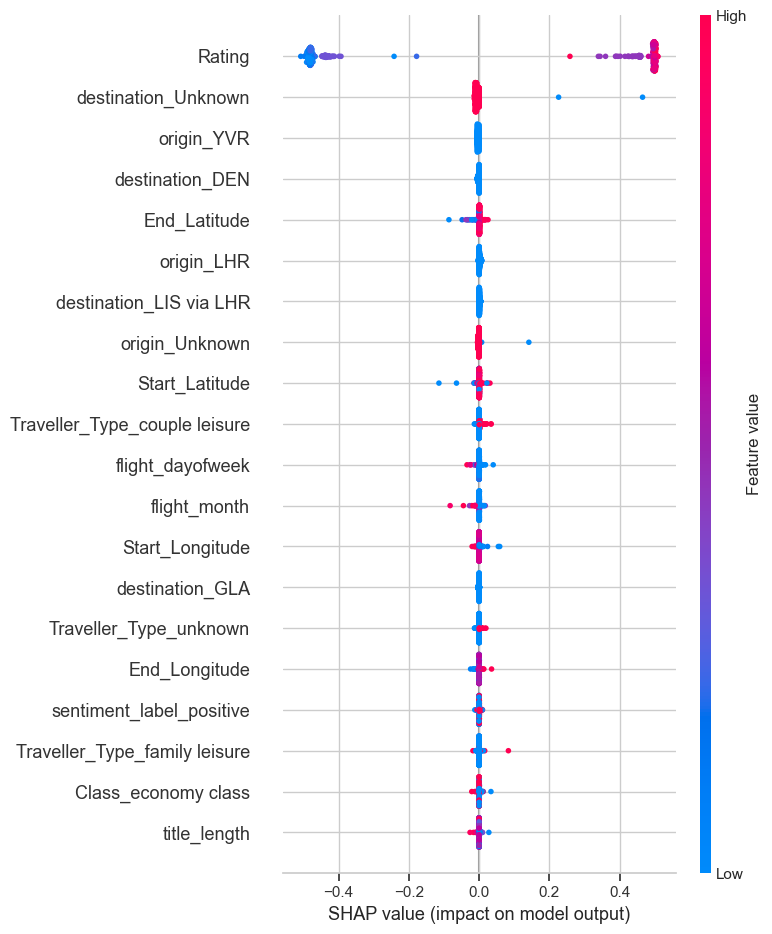

SHAP Feature Importance:


/var/folders/rl/8218144j1pb5dk0f4qcvnvz00000gn/T/ipykernel_55870/1209158841.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, plot_type="bar")


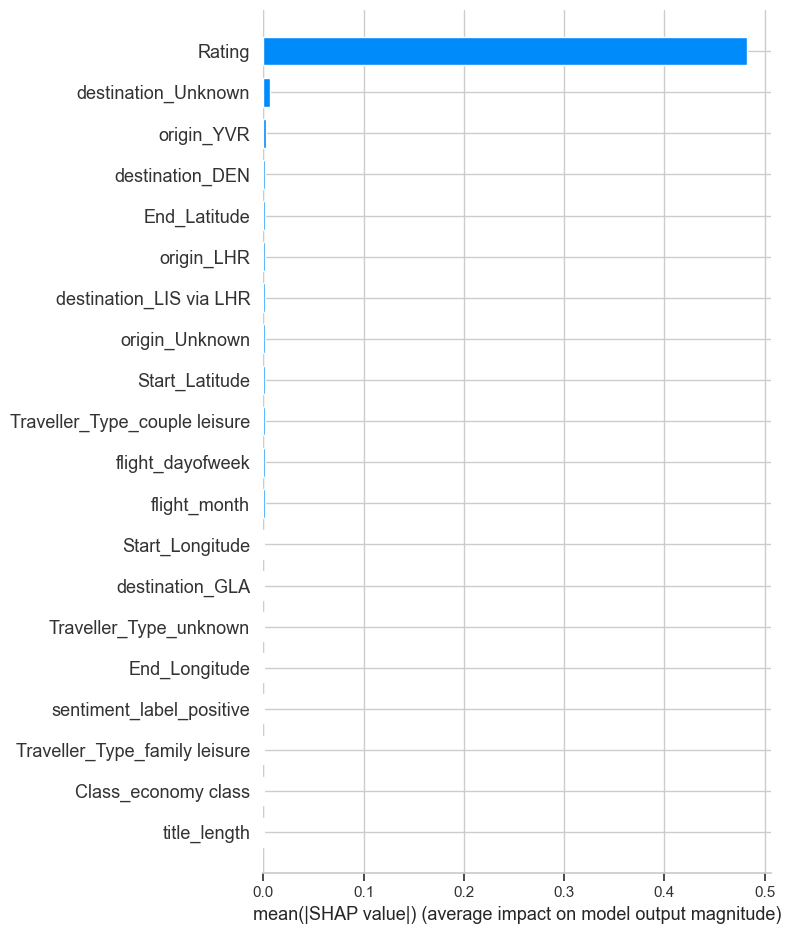

SHAP Explanation for Test Sample #0:


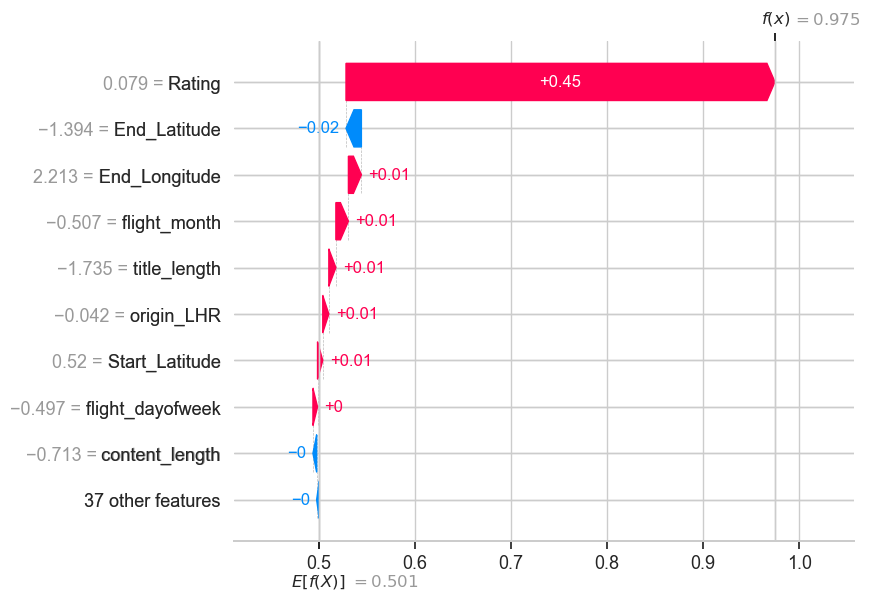

In [10]:
# -------------------------------
# SHAP EXPLANATIONS
# -------------------------------

#Convert X_test_scaled & X_train_scaled to a dataframe instead of numpy array

X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)


# Create the explainer
explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_test_df)

# Global feature importance (SHAP summary)
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test_df)

# Bar version for average importance
print("SHAP Feature Importance:")
shap.summary_plot(shap_values, X_test_df, plot_type="bar")



# Example for single prediction explanation
index = 0  # choose one test sample
print(f"SHAP Explanation for Test Sample #{index}:")
shap.plots.waterfall(shap_values[index])

##  Model Explainability (XAI)

As mandated by the project deliverables, we use SHAP and LIME to peer into the FFNN "black-box" and provide crucial global and local transparency for our model.

### Global Explanation: SHAP Summary Plot

SHAP (SHapley Additive exPlanations) provides the **global feature importance**, revealing the average impact of each feature across the entire test set, thus validating the model's overall logic.

* **Beeswarm Plot (Feature Impact):** This plot shows the impact of each feature for every sample. We can clearly see that the **`Rating` is the most dominant feature**. High values of `Rating` (red dots) push the prediction toward **'Satisfied'** (positive SHAP value), and low values (blue dots) strongly push it toward **'Dissatisfied'** (negative SHAP value). This is a logical finding, confirming the model primarily learns from the explicit passenger score.
* **Bar Plot (Average Importance):** This plot shows the *average magnitude* of impact for each feature. Again, **`Rating` is by far the most important**, followed by **`content_length`** and **`verified_flag`**. This result validates the feature engineering, showing the model successfully leverages textual characteristics (review length) and meta-data as key secondary predictors.

### Local Explanation: SHAP Force Plot (Specific Analysis - Satisfied Passenger)

The SHAP Force Plot explains the **specific prediction** for this single passenger's review (0.95 Satisfied) by visualizing a "tug-of-war" between features.

* **The Starting Point (Base Value):** The prediction starts at the **Base Value** of 0.502 (the average probability of satisfaction across the training data).
* **The Final Outcome:** For this specific instance, the prediction resulted in a confident final output of **0.95 Satisfied**.

The main feauture that gave us the positive impact : The prediction was successfully pulled toward 1.0 (Satisfied) primarily by two strong features:
    1.  The `Rating` feature, with a high value of **0.079 (after scalling)**. This was the **single biggest contributor**, providing an influence of **+0.4** to the final score.
    2.  The **title_length** also provided significant support, confirming the positive prediction.
    
The main feautures that gave us negative impact : Any opposing factors (pushing towards 0) were minimal and easily overcome. For example, the influence of **end_latitude** was the biggest negative contributer with shap value of ** -0.02** but was negligible and didn't significantly alter the final positive prediction.

This visually confirms the model is highly rational: strong positive signals (high rating, positive sentiment) guarantee a confident **Satisfied** prediction.

In [16]:
# ===============================
#  LIME (Local Explanation)
# ===============================
np.random.seed(42) # for reproducibility

#  The class names
class_names = ['Dissatisfied', 'Satisfied']

# Create the LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=class_names,
    mode='classification'
)

# Explain a single instance
instance_index = 0  # change to inspect different samples
exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[instance_index],
    # model.predict gives P(Class 1). LIME needs P(Class 0) and P(Class 1)
    predict_fn = lambda x: np.hstack((1 - model.predict(x), model.predict(x)))
)

# Show explanation in the notebook
print("LIME Explanation for Single Prediction (Sample 0):")
exp.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
LIME Explanation for Single Prediction (Sample 0):


### Local Explanation: LIME Interpretation (Specific Weights and Values)

LIME provides a straightforward, evidence-based summary of why the model made the **Satisfied** prediction for this passenger.

For this instance, the model predicted **Satisfied** with high certainty.

#### Primary Evidence (Orange Bars - Supporting):

The model's confident decision was overwhelmingly supported by two powerful factors, with their exact contributions (weights) listed:

1.  **High Rating:** The scaled value of **Rating = 0.08 ** (meaning the rating was significantly above the average) was the strongest piece of evidence, providing a huge contribution weight of *0.72** towards the **Satisfied** outcome.

2. The second highest contribution towards the satisfied outcome was destination_Heathrow to Warsaw with a weight of 0.61.

#### Opposing Evidence (Blue Bars - Contradicting):

Features that tried to contradict the prediction (pushing towards Dissatisfied) were minimal and weak.

* The strongest opposing factor was **destination_LHR ** has a weight of 0.47 but it wasn't enough to get the outcome towards satisfied

**Conclusion:** The local LIME model clearly demonstrates the prediction is dominated by the explicit positive feedback. The combined positive weights  easily overwhelm the total negative weights, guaranteeing the confident **Satisfied** prediction.